TODO disaster selection:
* tornado higgest category : EF 5
* Earthquakes: 7.0 magnitude and higher
* hurricane max wind speed > 155 is category 5
* tornados, floods, and blizzards all in FEMA, so just use if declaration type is emergency

In [1]:
# Imports

%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import sqlite3

# Utils

def matches_date_regex(s):
    return bool(re.match(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', s))

def get_prices_from_housing_data(df):
    return df[[x for x in df.columns if matches_date_regex(x)]]

def get_average_prices_for_years(housing_data, years, output_column):
    str_years = [str(y) for y in years]
    housing_data[output_column] = get_prices_from_housing_data(
        housing_data
    )[[
        x for x in housing_data.columns
        if x[:4] in str_years
    ]].T.mean()

def get_average_price_changes_for_years(housing_data, years, output_column):
    str_years = [str(y) for y in years]
    housing_data[output_column] = get_prices_from_housing_data(
        housing_data
    )[[
        x for x in housing_data.columns
        if x[:4] in str_years
    ]].T.pct_change().mean()

def calculate_distances_to_disaster(housing_data, disaster_latitudes, disaster_longitudes, output_column):
    temp_housing_data = housing_data
    coords = list(zip(disaster_latitudes, disaster_longitudes))

    if output_column in temp_housing_data:
        del temp_housing_data[output_column]

    for i in range(len(coords)):
        dist = np.sqrt(
            (temp_housing_data['clat10'] - coords[i][0]) ** 2 +
            (temp_housing_data['clon10'] - coords[i][1]) ** 2
        )
        if output_column not in temp_housing_data:
            temp_housing_data[output_column] = dist
        else:
            d = {}
            d[output_column] = dist
            df = pd.DataFrame(d)
            temp_housing_data = temp_housing_data.combine(df, np.minimum, overwrite=False)

    housing_data[output_column] = temp_housing_data[output_column]

def filter_housing_data_by_years(housing_data, years):
    str_years = [str(y) for y in years]
    return housing_data[[
        x for x in housing_data.columns
        if x[:4] in str_years or not matches_date_regex(x)
    ]].dropna(thresh=26)

In [2]:
# Input data setup

dataset_selection = {
    '188-million-us-wildfires': [
        'FPA_FOD_20170508.sqlite',
    ],
    'county-centers' : [
        'county_centers.csv',
    ],
    'federal-disasters': [
        'database.csv',
    ],
    'hurricane-database': [
        'atlantic.csv',
        'pacific.csv',
    ],
    'earthquake-database': [
        'database.csv',
    ],
    'zhvi-county': [
        'County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon (4).csv',
    ],
}


# Dataframe generation

available_datasets = os.listdir('/kaggle/input')
print(f'Available datasets: {available_datasets}')

datasets = {}
num_datasets = 0

for name, files in dataset_selection.items():
    datasets[name] = [x for x in os.listdir(f'/kaggle/input/{name}') if x in files]
    num_datasets += len(datasets[name])

print(f'{num_datasets} datasets loaded: {datasets}')

def read_file(filename):
    if filename[-4:] == '.csv':
        return pd.read_csv(filename)
    elif filename[-7:] == '.sqlite':
        con = sqlite3.connect(filename)
        result = pd.read_sql_query("SELECT * from fires", con)
        con.close()
        return result
    return None

data = {}

for name, files in datasets.items():
    data[name] = {x[0]: x[1] for x in [(file, read_file(f'/kaggle/input/{name}/{file}')) for file in files]}


# Dataframe variables

wildfires_data = data['188-million-us-wildfires']['FPA_FOD_20170508.sqlite']
counties_data = data['county-centers']['county_centers.csv']
disasters_data = data['federal-disasters']['database.csv']
hurricane_atlantic_data = data['hurricane-database']['atlantic.csv']
hurricane_pacific_data = data['hurricane-database']['pacific.csv']
earthquake_data = data['earthquake-database']['database.csv']
housing_data = data['zhvi-county']['County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon (4).csv']

Available datasets: ['188-million-us-wildfires', 'federal-disasters', 'county-centers', 'earthquake-database', 'zhvi-county', 'hurricane-database']
7 datasets loaded: {'188-million-us-wildfires': ['FPA_FOD_20170508.sqlite'], 'county-centers': ['county_centers.csv'], 'federal-disasters': ['database.csv'], 'hurricane-database': ['atlantic.csv', 'pacific.csv'], 'earthquake-database': ['database.csv'], 'zhvi-county': ['County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon (4).csv']}


In [3]:
wildfires_data

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...


In [4]:
counties_data

,fips,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0,1001,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1,1003,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2,1005,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3,1007,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4,1009,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243
...,...,...,...,...,...,...,...,...,...
3142,56037,-109.168198,41.640708,-108.875676,41.660339,-109.302230,41.577416,-109.295115,41.580266
3143,56039,-110.673534,43.612124,-110.588102,44.049320,-110.779920,43.501456,-110.784353,43.494174
3144,56041,-110.599878,41.283917,-110.558947,41.284726,-110.771650,41.273058,-110.767519,41.271860
3145,56043,-107.728972,43.960220,-107.669052,43.878831,-107.909260,44.011935,-107.911552,44.012142


In [5]:
disasters_data

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46180,DR-4301,Disaster,02/14/2017,CA,Sutter County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes
46181,DR-4301,Disaster,02/14/2017,CA,Trinity County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes
46182,DR-4301,Disaster,02/14/2017,CA,Tuolumne County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes
46183,DR-4301,Disaster,02/14/2017,CA,Yolo County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes


In [6]:
hurricane_atlantic_data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0


In [7]:
try:
    hurricane_atlantic_data['Latitude'] = hurricane_atlantic_data['Latitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'S' else 1))
except:
    pass
try:
    hurricane_atlantic_data['Longitude'] = hurricane_atlantic_data['Longitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'W' else 1))
except:
    pass

hurricane_atlantic_data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3,-50.4,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9,-49.9,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5,-49.2,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8,-47.5,45,985,...,180,220,0,0,0,0,0,0,0,0


In [8]:
try:
    hurricane_pacific_data['Latitude'] = hurricane_pacific_data['Latitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'S' else 1))
except:
    pass
try:
    hurricane_pacific_data['Longitude'] = hurricane_pacific_data['Longitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'W' else 1))
except:
    pass

hurricane_pacific_data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,EP011949,UNNAMED,19490611,0,,TS,20.2,-106.3,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,EP011949,UNNAMED,19490611,600,,TS,20.2,-106.4,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,EP011949,UNNAMED,19490611,1200,,TS,20.2,-106.7,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,EP011949,UNNAMED,19490611,1800,,TS,20.3,-107.7,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,EP011949,UNNAMED,19490612,0,,TS,20.4,-108.6,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26132,EP222015,SANDRA,20151128,1200,,LO,21.7,-109.0,35,1002,...,0,0,0,0,0,0,0,0,0,0
26133,EP222015,SANDRA,20151128,1800,,LO,22.4,-108.7,30,1007,...,0,0,0,0,0,0,0,0,0,0
26134,EP222015,SANDRA,20151129,0,,LO,23.1,-108.3,30,1008,...,0,0,0,0,0,0,0,0,0,0
26135,EP222015,SANDRA,20151129,600,,LO,23.5,-107.9,25,1009,...,0,0,0,0,0,0,0,0,0,0


In [9]:
earthquake_data

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,...,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,...,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,...,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,...,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


In [10]:
if 'FIPS' in housing_data:
    del housing_data['FIPS']
if 'clon10' in housing_data:
    del housing_data['clon10']
if 'clat10' in housing_data:
    del housing_data['clat10']

concat_fips = housing_data[['StateCodeFIPS', 'MunicipalCodeFIPS']].apply(lambda x: int(''.join([
    '00' + str(x[i]) if x[i] < 10
    else '0' + str(x[i]) if x[i] < 100
    else str(x[i])
    for i in range(len(x))
])), axis=1)

housing_data['FIPS'] = concat_fips

housing_data = pd.concat([housing_data.set_index('FIPS'), counties_data[['fips', 'clon10', 'clat10']].set_index('fips')], axis=1, join='inner')

housing_data.reset_index(drop=True)
counties_data.reset_index(drop=True)

housing_data['avg_price'] = get_prices_from_housing_data(housing_data).T.mean()
housing_data['avg_price_change'] = get_prices_from_housing_data(housing_data).T.pct_change().mean()

housing_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,clon10,clat10,avg_price,avg_price_change
6037,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,174806.0,...,652573.0,654414.0,655794.0,661051.0,668812.0,677628.0,-118.261862,34.196398,410148.074074,0.004630
17031,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,157181.0,...,258413.0,259057.0,259963.0,261565.0,263624.0,266504.0,-87.645455,41.894294,227501.922559,0.001811
48201,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,100825.0,...,203388.0,204435.0,205211.0,206161.0,207293.0,209145.0,-95.393037,29.857273,140084.925926,0.002475
4013,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,115807.0,...,301917.0,305069.0,307947.0,310740.0,314456.0,318895.0,-112.495534,33.346541,197261.474747,0.003489
6073,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,177310.0,...,607043.0,610945.0,613668.0,617391.0,623359.0,632264.0,-116.776117,33.023604,404767.420875,0.004345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16025,425,3101,Camas County,County,ID,ID,Hailey,16,25,NaN,...,152946.0,153614.0,154370.0,155290.0,156251.0,157501.0,-114.804427,43.463396,125456.993464,-0.000077
49009,1648,3102,Daggett County,County,UT,UT,NaN,49,9,NaN,...,197781.0,198238.0,198682.0,199726.0,200607.0,201642.0,-109.505785,40.890099,151774.058824,0.004837
8053,2345,3112,Hinsdale County,County,CO,CO,NaN,8,53,NaN,...,367083.0,366892.0,366824.0,368134.0,368727.0,369449.0,-107.383405,37.811625,353830.608696,0.003064
8079,1933,3122,Mineral County,County,CO,CO,NaN,8,79,NaN,...,275602.0,275883.0,276154.0,276582.0,277249.0,278179.0,-106.932300,37.651478,262989.444444,0.001345


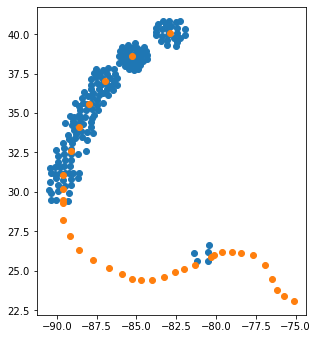

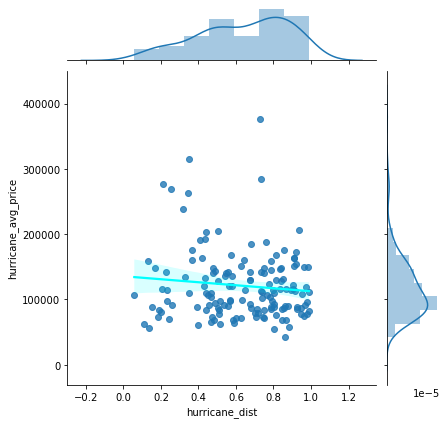

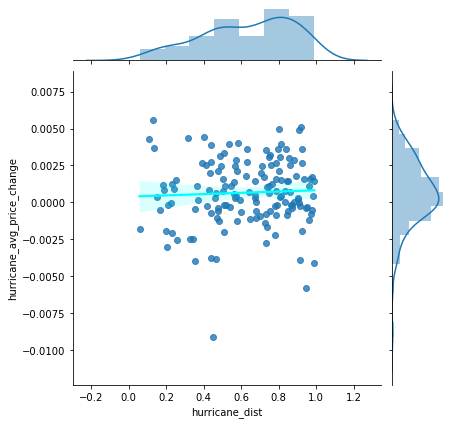

In [11]:
# Hurricane selection

hname = 'katrina'
hyear = 2005

hurricane_atlantic_data_selected = hurricane_atlantic_data[
    (hurricane_atlantic_data['Name'] == (' '*(19-len(hname)))+hname.upper())
    & (hurricane_atlantic_data['Date'] > hyear*10000)
]

# Hurricane distance calculation

calculate_distances_to_disaster(housing_data, hurricane_atlantic_data_selected['Latitude'], hurricane_atlantic_data_selected['Longitude'], 'hurricane_dist')

# Housing data filter for selected hurricane

hurricane_max_dist = 1
hurricane_years = range(2005, 2009)

get_average_prices_for_years(housing_data, hurricane_years, 'hurricane_avg_price')
get_average_price_changes_for_years(housing_data, hurricane_years, 'hurricane_avg_price_change')

hurricane_housing_data = housing_data[
    housing_data['hurricane_dist'] < hurricane_max_dist
]

# Selected hurricane visualization

lat_range = hurricane_atlantic_data_selected['Latitude'].max() - hurricane_atlantic_data_selected['Latitude'].min()
long_range = hurricane_atlantic_data_selected['Longitude'].max() - hurricane_atlantic_data_selected['Longitude'].min()

plt.figure(figsize=(long_range / 3, lat_range / 3))
plt.scatter(hurricane_housing_data['clon10'], hurricane_housing_data['clat10'])
plt.scatter(hurricane_atlantic_data_selected['Longitude'], hurricane_atlantic_data_selected['Latitude'])

# Linear regression on housing distances to selected hurricane

sns.jointplot(x="hurricane_dist", y="hurricane_avg_price", data=hurricane_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})
sns.jointplot(x="hurricane_dist", y="hurricane_avg_price_change", data=hurricane_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

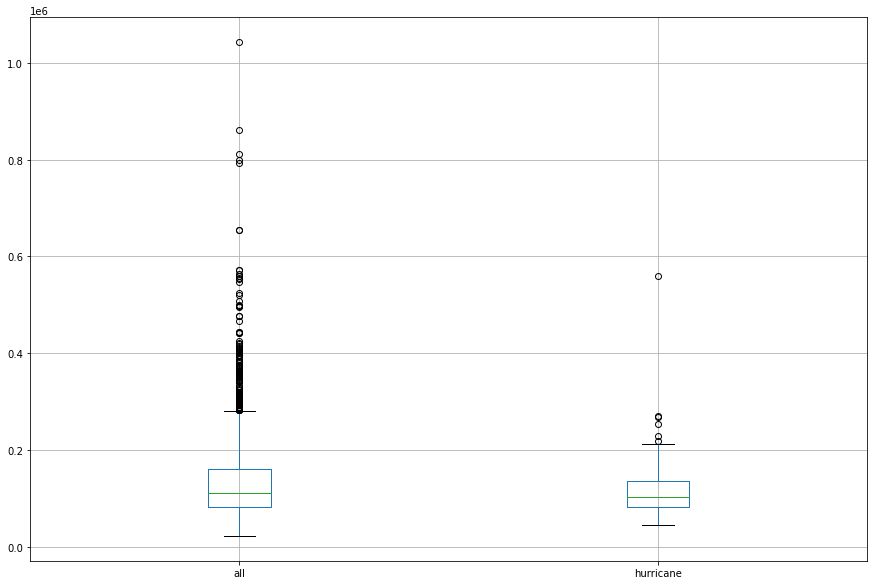

In [12]:
pd.DataFrame({
    'all': housing_data['avg_price'],
    'hurricane': hurricane_housing_data['avg_price'],
}).boxplot(figsize=(15, 10))

In [13]:
# hurricane_avg_price ~ hurricane_dist

y, X = dmatrices('hurricane_avg_price ~ hurricane_dist', data=hurricane_housing_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     hurricane_avg_price   R-squared:                       0.011
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     1.653
Date:                 Fri, 04 Dec 2020   Prob (F-statistic):              0.201
Time:                         22:16:39   Log-Likelihood:                -1817.1
No. Observations:                  148   AIC:                             3638.
Df Residuals:                      146   BIC:                             3644.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.356e+05   1.21e+04     11.189      0.000    1.12e+05     1.6e+05
hurricane_dist -2.302e+04   1.79e+04     -1.286      0.201   -5.84e+04    1.24e+04
==============================================================================
Omnibus:                       66.375   Durbin-Watson:                   0.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.714
Skew:                           1.760   Prob(JB):                     6.45e-47
Kurtosis:                       7.701   Cond. No.                         5.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# hurricane_avg_price_change ~ hurricane_dist

y, X = dmatrices('hurricane_avg_price_change ~ hurricane_dist', data=hurricane_housing_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     hurricane_avg_price_change   R-squared:                       0.002
Model:                                    OLS   Adj. R-squared:                 -0.005
Method:                         Least Squares   F-statistic:                    0.3196
Date:                        Fri, 04 Dec 2020   Prob (F-statistic):              0.573
Time:                                22:16:39   Log-Likelihood:                 693.37
No. Observations:                         148   AIC:                            -1383.
Df Residuals:                             146   BIC:                            -1377.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0004      0.001      0.743      0.459      -0.001       0.001
hurricane_dist     0.0004      0.001      0.565      0.573      -0.001       0.002
==============================================================================
Omnibus:                       18.020   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.063
Skew:                          -0.617   Prob(JB):                     4.89e-07
Kurtosis:                       4.786   Cond. No.                         5.90
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

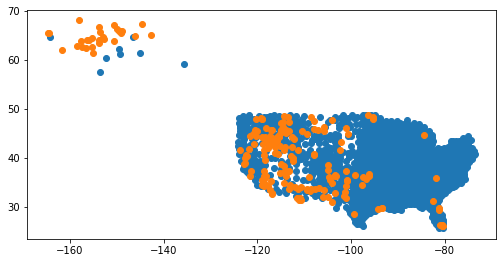

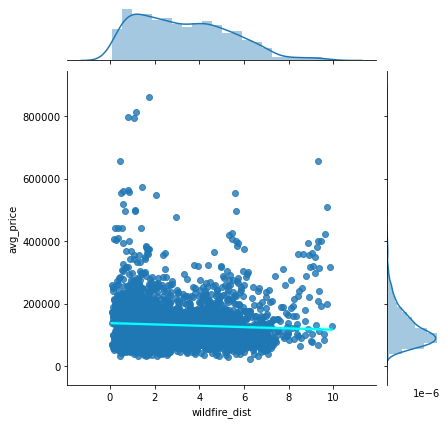

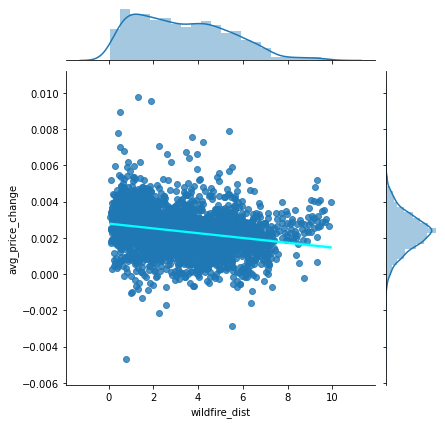

In [15]:
# Wildfire selection

wsizes = ['G']

wildfires_data_selected = wildfires_data[
    wildfires_data['FIRE_SIZE_CLASS'].isin(wsizes)
].sample(200)

# Wildfire distance calculation

calculate_distances_to_disaster(housing_data, wildfires_data_selected['LATITUDE'], wildfires_data_selected['LONGITUDE'], 'wildfire_dist')

# Housing data filter for selected wildfire

wildfire_max_dist = 10

wildfire_housing_data = housing_data[
    housing_data['wildfire_dist'] < wildfire_max_dist
]

# Selected wildfire visualization

lat_range = wildfires_data_selected['LATITUDE'].max() - wildfires_data_selected['LATITUDE'].min()
long_range = wildfires_data_selected['LONGITUDE'].max() - wildfires_data_selected['LONGITUDE'].min()

plt.figure(figsize=(long_range / 10, lat_range / 10))
plt.scatter(wildfire_housing_data['clon10'], wildfire_housing_data['clat10'])
plt.scatter(wildfires_data_selected['LONGITUDE'], wildfires_data_selected['LATITUDE'])

# Linear regression on housing distances to selected wildfires

sns.jointplot(x="wildfire_dist", y="avg_price", data=wildfire_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})
sns.jointplot(x="wildfire_dist", y="avg_price_change", data=wildfire_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

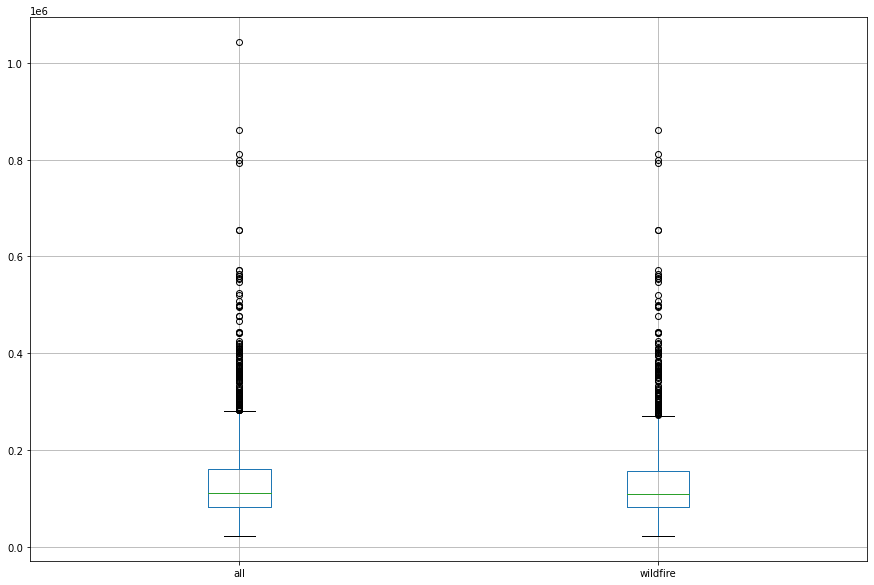

In [16]:
pd.DataFrame({
    'all': housing_data['avg_price'],
    'wildfire': wildfire_housing_data['avg_price'],
}).boxplot(figsize=(15, 10))

In [17]:
# avg_price ~ wildfire_dist

y, X = dmatrices('avg_price ~ wildfire_dist', data=wildfire_housing_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.988
Date:                Fri, 04 Dec 2020   Prob (F-statistic):            0.00274
Time:                        22:17:42   Log-Likelihood:                -34946.
No. Observations:                2758   AIC:                         6.990e+04
Df Residuals:                    2756   BIC:                         6.991e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.373e+05   2761.369     49.705      0.000    1.32e+05    1.43e+05
wildfire_dist -2122.7036    708.036     -2.998      0.003   -3511.039    -734.368
==============================================================================
Omnibus:                     1766.081   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27184.030
Skew:                           2.805   Prob(JB):                         0.00
Kurtosis:                      17.321   Cond. No.                         7.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# avg_price_change ~ wildfire_dist

y, X = dmatrices('avg_price_change ~ wildfire_dist', data=wildfire_housing_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       avg_price_change   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     160.9
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           7.12e-36
Time:                        22:17:42   Log-Likelihood:                 14793.
No. Observations:                2758   AIC:                        -2.958e+04
Df Residuals:                    2756   BIC:                        -2.957e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0028   4.06e-05     68.639      0.000       0.003       0.003
wildfire_dist    -0.0001   1.04e-05    -12.684      0.000      -0.000      -0.000
==============================================================================
Omnibus:                      273.091   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1329.078
Skew:                           0.350   Prob(JB):                    2.48e-289
Kurtosis:                       6.328   Cond. No.                         7.69
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# avg_price_change ~ wildfire_dist + avg_price

y, X = dmatrices('avg_price_change ~ wildfire_dist + avg_price', data=wildfire_housing_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       avg_price_change   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     149.7
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           1.84e-62
Time:                        22:17:43   Log-Likelihood:                 14857.
No. Observations:                2758   AIC:                        -2.971e+04
Df Residuals:                    2755   BIC:                        -2.969e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0024   5.47e-05     43.136      0.000       0.002       0.002
wildfire_dist    -0.0001   1.02e-05    -12.306      0.000      -0.000      -0.000
avg_price      3.135e-09   2.74e-10     11.446      0.000     2.6e-09    3.67e-09
==============================================================================
Omnibus:                      337.646   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1979.347
Skew:                           0.421   Prob(JB):                         0.00
Kurtosis:                       7.064   Cond. No.                     3.95e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

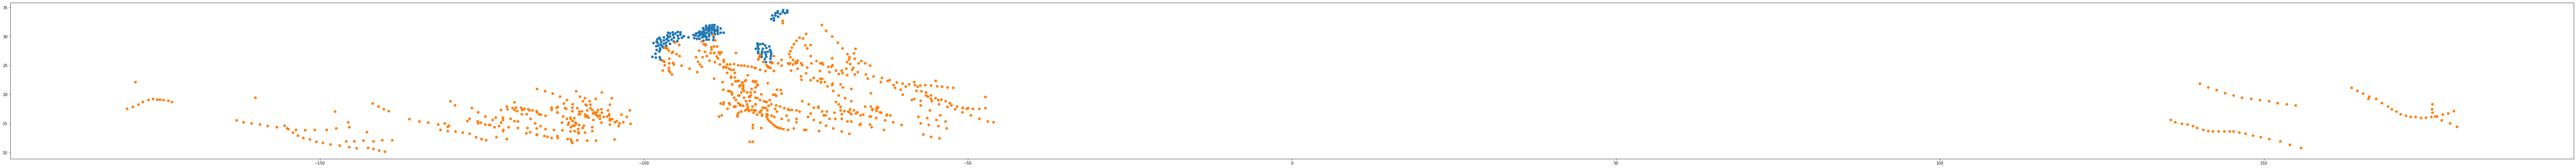

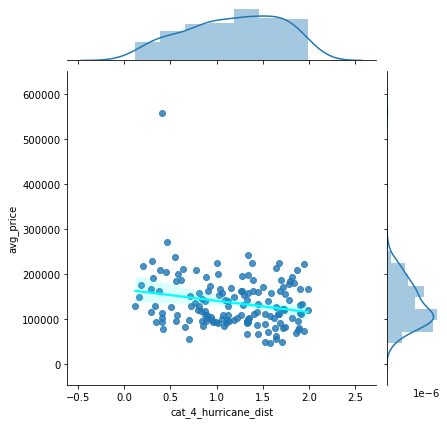

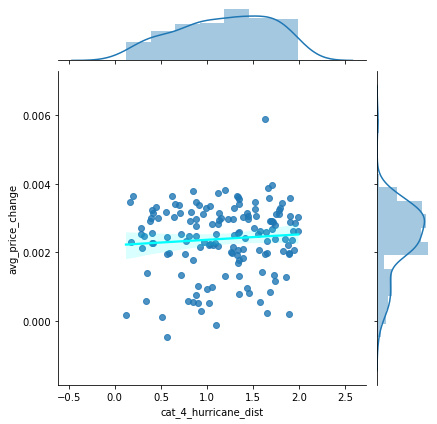

In [20]:
# Hurricane selection

cat_4_hurricanes = hurricane_pacific_data[hurricane_pacific_data['Maximum Wind'] > 120].append(hurricane_atlantic_data[hurricane_atlantic_data['Maximum Wind'] > 120], ignore_index=True)

# Hurricane distance calculation

calculate_distances_to_disaster(housing_data, cat_4_hurricanes['Latitude'], cat_4_hurricanes['Longitude'], 'cat_4_hurricane_dist')

# Housing data filter for selected hurricanes

hurricane_max_dist = 2

cat_4_hurricane_housing_data = housing_data[
    housing_data['cat_4_hurricane_dist'] < hurricane_max_dist
]

# Selected hurricanes visualization

lat_range = cat_4_hurricanes['Latitude'].max() - cat_4_hurricanes['Latitude'].min()
long_range = cat_4_hurricanes['Longitude'].max() - cat_4_hurricanes['Longitude'].min()

plt.figure(figsize=(long_range / 3, lat_range / 3))
plt.scatter(cat_4_hurricane_housing_data['clon10'], cat_4_hurricane_housing_data['clat10'])
plt.scatter(cat_4_hurricanes['Longitude'], cat_4_hurricanes['Latitude'])

# Linear regression on housing distances to selected hurricanes

sns.jointplot(x="cat_4_hurricane_dist", y="avg_price", data=cat_4_hurricane_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})
sns.jointplot(x="cat_4_hurricane_dist", y="avg_price_change", data=cat_4_hurricane_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

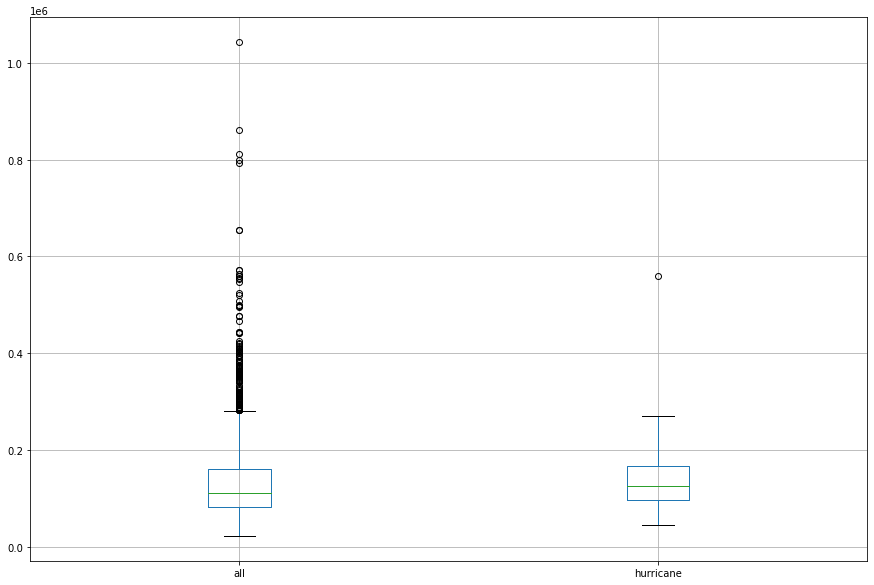

In [21]:
pd.DataFrame({
    'all': housing_data['avg_price'],
    'hurricane': cat_4_hurricane_housing_data['avg_price'],
}).boxplot(figsize=(15, 10))

In [22]:
earthquake_data[earthquake_data['Magnitude'] > 7.5]

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
11,01/24/1965,00:11:17,-2.6080,125.9520,Earthquake,20.00,NaN,NaN,8.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM861299,ISCGEM,ISCGEM,ISCGEM,Automatic
16,02/04/1965,05:01:22,51.2510,178.7150,Earthquake,30.30,NaN,NaN,8.7,MW,...,NaN,NaN,NaN,NaN,NaN,OFFICIAL19650204050122_30,OFFICIAL,ISCGEM,OFFICIAL,Automatic
103,03/30/1965,02:27:06,50.2820,177.9590,Earthquake,20.00,NaN,NaN,7.6,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM858982,ISCGEM,ISCGEM,ISCGEM,Automatic
152,05/20/1965,00:40:27,-14.9210,167.3400,Earthquake,120.00,NaN,NaN,7.7,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM857011,ISCGEM,ISCGEM,ISCGEM,Automatic
193,07/02/1965,20:58:40,52.9900,-167.7390,Earthquake,45.00,NaN,NaN,7.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM855112,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23193,07/29/2016,21:18:25,18.5429,145.5073,Earthquake,196.00,1.8,NaN,7.7,MWW,...,NaN,14.0,3.294,7.5,1.38,US100068JG,US,US,US,Reviewed
23326,11/13/2016,11:02:56,-42.7358,173.0499,Earthquake,15.22,3.2,NaN,7.8,MWW,...,NaN,21.0,0.482,4.6,0.57,US1000778I,US,US,US,Reviewed
23369,12/08/2016,17:38:46,-10.6787,161.3214,Earthquake,40.00,1.8,NaN,7.8,MWW,...,NaN,13.0,1.830,8.2,0.87,US20007Z80,US,US,US,Reviewed
23386,12/17/2016,10:51:10,-4.5049,153.5216,Earthquake,94.54,3.8,NaN,7.9,MWW,...,NaN,13.0,1.389,7.3,0.97,US200081V8,US,US,US,Reviewed


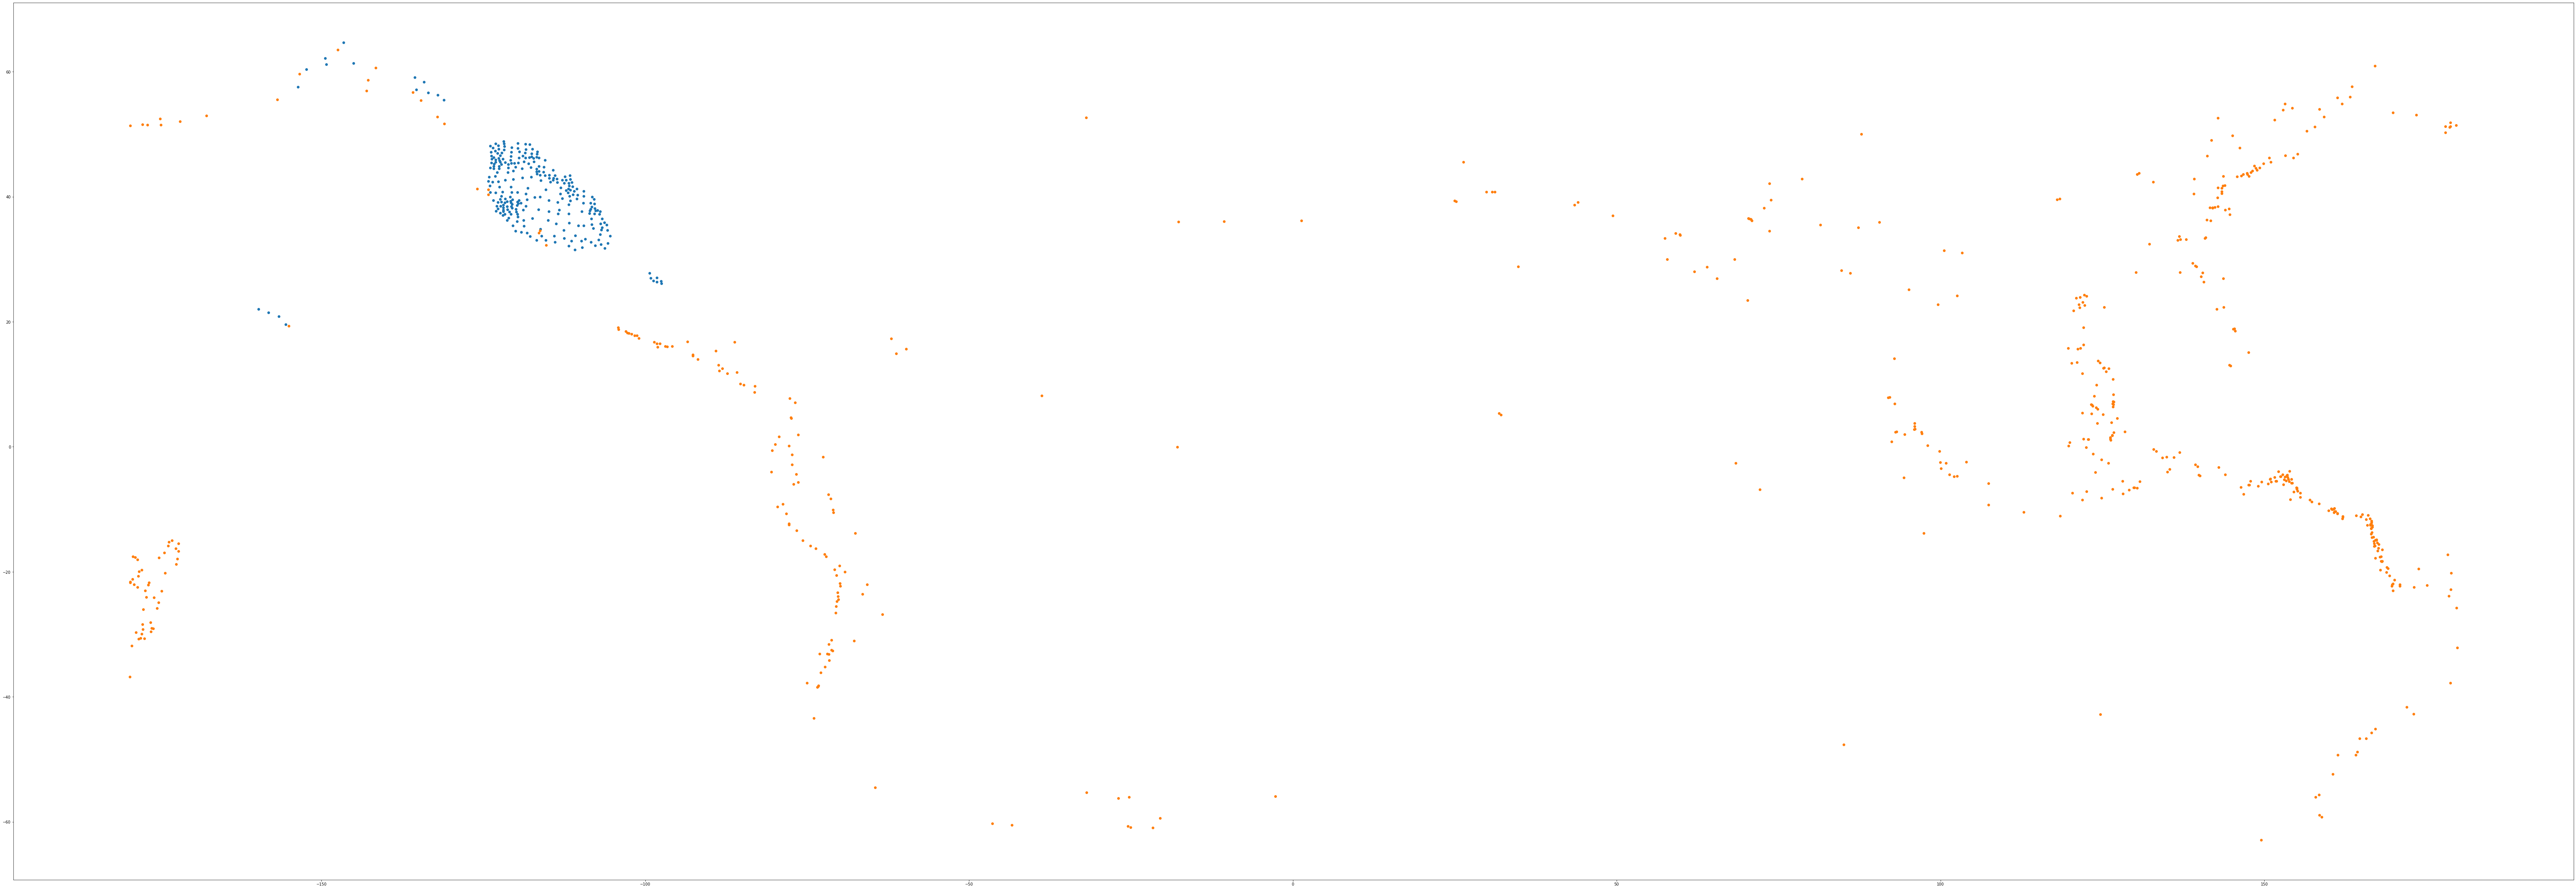

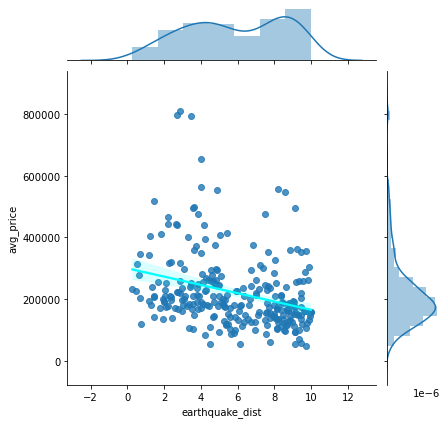

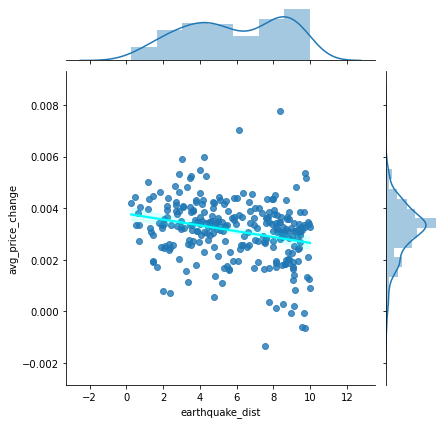

In [23]:
# Earthquake selection

earthquake_data_selected = earthquake_data[earthquake_data['Magnitude'] > 7]

# Earthquake distance calculation

calculate_distances_to_disaster(housing_data, earthquake_data_selected['Latitude'], earthquake_data_selected['Longitude'], 'earthquake_dist')

# Housing data filter for selected earthquakes

earthquake_max_dist = 10

earthquake_housing_data = housing_data[
    housing_data['earthquake_dist'] < earthquake_max_dist
]

# Selected earthquakes visualization

lat_range = earthquake_data_selected['Latitude'].max() - earthquake_data_selected['Latitude'].min()
long_range = earthquake_data_selected['Longitude'].max() - earthquake_data_selected['Longitude'].min()

plt.figure(figsize=(long_range / 3, lat_range / 3))
plt.scatter(earthquake_housing_data['clon10'], earthquake_housing_data['clat10'])
plt.scatter(earthquake_data_selected['Longitude'], earthquake_data_selected['Latitude'])

# Linear regression on housing distances to selected earthquakes

sns.jointplot(x="earthquake_dist", y="avg_price", data=earthquake_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})
sns.jointplot(x="earthquake_dist", y="avg_price_change", data=earthquake_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

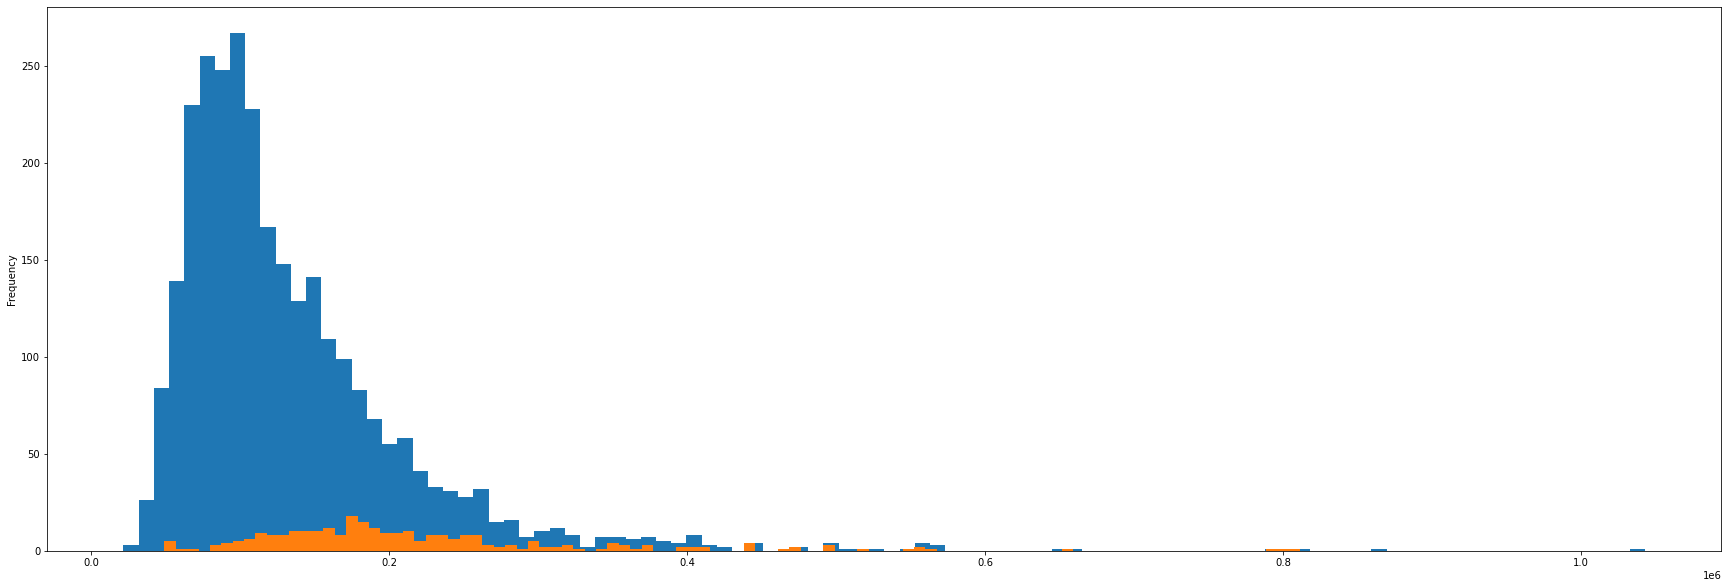

In [24]:
housing_data['avg_price'].plot.hist(bins=100, figsize=(30, 10))
earthquake_housing_data['avg_price'].plot.hist(bins=100, figsize=(30, 10))

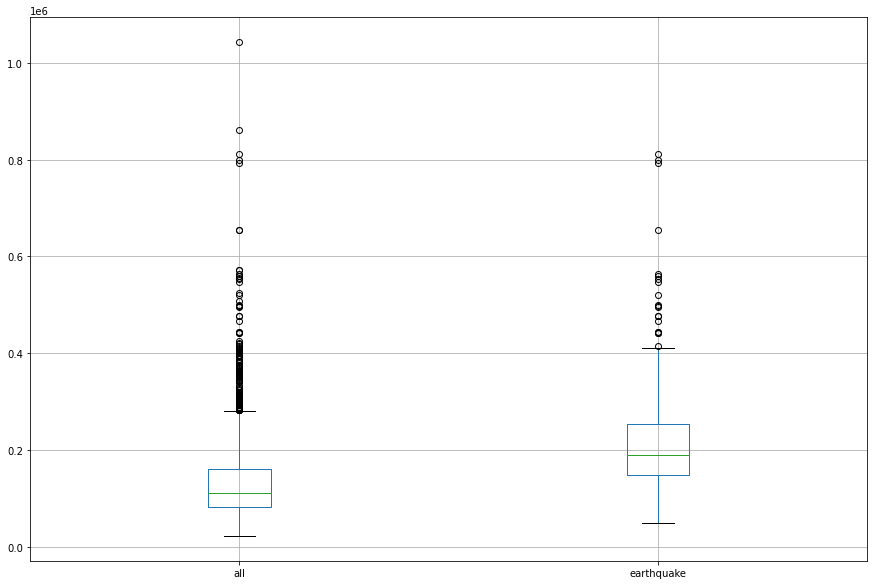

In [25]:
pd.DataFrame({
    'all': housing_data['avg_price'],
    'earthquake': earthquake_housing_data['avg_price'],
}).boxplot(figsize=(15, 10))